<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Scale-and-Average-Readability-Scores" data-toc-modified-id="Scale-and-Average-Readability-Scores-1">Scale and Average Readability Scores</a></span></li><li><span><a href="#Volume-Count" data-toc-modified-id="Volume-Count-2">Volume Count</a></span></li><li><span><a href="#Summarize-by-Day-for-each-Stock" data-toc-modified-id="Summarize-by-Day-for-each-Stock-3">Summarize by Day for each Stock</a></span></li><li><span><a href="#Merge-Finalized-Data-with-Return-Data" data-toc-modified-id="Merge-Finalized-Data-with-Return-Data-4">Merge Finalized Data with Return Data</a></span></li><li><span><a href="#Fix-Weekend-and-Holiday-rows-(missing-Ticker)" data-toc-modified-id="Fix-Weekend-and-Holiday-rows-(missing-Ticker)-5">Fix Weekend and Holiday rows (missing Ticker)</a></span><ul class="toc-item"><li><span><a href="#Recount-Volume-for-Weekend-and-Holiday-data" data-toc-modified-id="Recount-Volume-for-Weekend-and-Holiday-data-5.1">Recount Volume for Weekend and Holiday data</a></span></li><li><span><a href="#Resummarize-Weekend-and-Holiday-data" data-toc-modified-id="Resummarize-Weekend-and-Holiday-data-5.2">Resummarize Weekend and Holiday data</a></span></li></ul></li><li><span><a href="#Fix-Missing-News-Sentiment-(missing-Tags)" data-toc-modified-id="Fix-Missing-News-Sentiment-(missing-Tags)-6">Fix Missing News Sentiment (missing Tags)</a></span><ul class="toc-item"><li><span><a href="#Merge-Lag-Sentiments" data-toc-modified-id="Merge-Lag-Sentiments-6.1">Merge Lag Sentiments</a></span></li></ul></li></ul></div>

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import datetime as dt
from datetime import datetime, timedelta

In [2]:
nlp_df = pd.read_csv("../00-data/aws_data/nlp_jan2021.csv").drop(["FleschReadingEase","words", "complex_words"], axis=1)# update with finalized data
nlp_df.head(5)

,year,month,day,website,url,pos_mean,pos_median,pos_min,pos_max,neg_mean,...,net_max,Kincaid,ARI,Coleman-Liau,GunningFogIndex,LIX,SMOGIndex,RIX,DaleChallIndex,tags
0,2021,1,1,yahoo.com,https://news.yahoo.com/amazon-fire-tv-india-23...,0.00,0.0,0.0,0.0,0.00,...,0.0,6.27,8.79,8.59,10.37,38.30,9.32,3.67,10.44,AMZN
1,2021,1,1,yahoo.com,https://news.yahoo.com/red-hot-buccaneers-not-...,0.22,0.0,0.0,1.0,0.12,...,1.0,5.37,7.42,7.41,9.84,33.51,9.01,2.79,9.47,T
2,2021,1,1,yahoo.com,https://news.yahoo.com/walt-disney-dis-gains-l...,0.37,0.0,0.0,1.0,0.15,...,1.0,7.90,9.74,9.76,13.99,44.09,12.55,4.76,13.10,DIS
3,2021,1,1,yahoo.com,https://news.yahoo.com/walt-disney-dis-gains-l...,0.37,0.0,0.0,1.0,0.15,...,1.0,7.90,9.74,9.76,13.99,44.09,12.55,4.76,13.10,DOW
4,2021,1,1,yahoo.com,https://news.yahoo.com/walt-disney-dis-gains-l...,0.37,0.0,0.0,1.0,0.15,...,1.0,7.90,9.74,9.76,13.99,44.09,12.55,4.76,13.10,NDAQ


## Scale and Average Readability Scores

In [3]:
nlp_df.columns

Index(['year', 'month', 'day', 'website', 'url', 'pos_mean', 'pos_median',
       'pos_min', 'pos_max', 'neg_mean', 'neg_median', 'neg_min', 'neg_max',
       'neu_mean', 'neu_median', 'neu_min', 'neu_max', 'net_mean',
       'net_median', 'net_min', 'net_max', 'Kincaid', 'ARI', 'Coleman-Liau',
       'GunningFogIndex', 'LIX', 'SMOGIndex', 'RIX', 'DaleChallIndex', 'tags'],
      dtype='object')

In [4]:
read_cols = ['Kincaid', 'ARI', 'Coleman-Liau',
             'GunningFogIndex', 'LIX', 'SMOGIndex', 'RIX', 'DaleChallIndex']

In [5]:
scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(nlp_df[read_cols].to_numpy())
scaled_df = pd.DataFrame(scaled_df, columns=read_cols)
scaled_df.head()

,Kincaid,ARI,Coleman-Liau,GunningFogIndex,LIX,SMOGIndex,RIX,DaleChallIndex
0,0.283100,0.242230,0.611583,0.195996,0.199843,0.223260,0.097302,0.239575
1,0.264597,0.218441,0.582127,0.184205,0.158169,0.210102,0.072044,0.160262
2,0.316612,0.258725,0.640789,0.276529,0.250218,0.360357,0.128588,0.457073
3,0.316612,0.258725,0.640789,0.276529,0.250218,0.360357,0.128588,0.457073
4,0.316612,0.258725,0.640789,0.276529,0.250218,0.360357,0.128588,0.457073


In [6]:
scaled_df['read_score'] = scaled_df[read_cols].mean(axis=1)
scaled_df = scaled_df.drop(read_cols,axis=1)
scaled_df.head()

,read_score
0,0.261611
1,0.231243
2,0.336111
3,0.336111
4,0.336111


In [7]:
scaled_df = nlp_df.join(scaled_df).drop(read_cols,axis=1)
scaled_df.head()

,year,month,day,website,url,pos_mean,pos_median,pos_min,pos_max,neg_mean,...,neu_mean,neu_median,neu_min,neu_max,net_mean,net_median,net_min,net_max,tags,read_score
0,2021,1,1,yahoo.com,https://news.yahoo.com/amazon-fire-tv-india-23...,0.00,0.0,0.0,0.0,0.00,...,1.00,1.00,1.0,1.0,0.00,-0.0,-0.00,0.0,AMZN,0.261611
1,2021,1,1,yahoo.com,https://news.yahoo.com/red-hot-buccaneers-not-...,0.22,0.0,0.0,1.0,0.12,...,0.66,0.99,0.0,1.0,0.10,0.0,-0.99,1.0,T,0.231243
2,2021,1,1,yahoo.com,https://news.yahoo.com/walt-disney-dis-gains-l...,0.37,0.0,0.0,1.0,0.15,...,0.48,0.02,0.0,1.0,0.22,0.0,-1.00,1.0,DIS,0.336111
3,2021,1,1,yahoo.com,https://news.yahoo.com/walt-disney-dis-gains-l...,0.37,0.0,0.0,1.0,0.15,...,0.48,0.02,0.0,1.0,0.22,0.0,-1.00,1.0,DOW,0.336111
4,2021,1,1,yahoo.com,https://news.yahoo.com/walt-disney-dis-gains-l...,0.37,0.0,0.0,1.0,0.15,...,0.48,0.02,0.0,1.0,0.22,0.0,-1.00,1.0,NDAQ,0.336111


## Volume Count

In [8]:
count_df = pd.DataFrame(scaled_df.groupby(["year", "month", "day", "tags"])["website"]
                        .count()).reset_index().rename(columns={"website":"volume"})
count_df.head()

,year,month,day,tags,volume
0,2021,1,1,AAPL,6
1,2021,1,1,ABBV,1
2,2021,1,1,ABT,1
3,2021,1,1,ADP,1
4,2021,1,1,ALGN,2


## Summarize by Day for each Stock

In [9]:
scaled_df.columns

Index(['year', 'month', 'day', 'website', 'url', 'pos_mean', 'pos_median',
       'pos_min', 'pos_max', 'neg_mean', 'neg_median', 'neg_min', 'neg_max',
       'neu_mean', 'neu_median', 'neu_min', 'neu_max', 'net_mean',
       'net_median', 'net_min', 'net_max', 'tags', 'read_score'],
      dtype='object')

In [10]:
summary_cols = ['pos_mean', 'pos_median',
       'pos_min', 'pos_max', 'neg_mean', 'neg_median', 'neg_min', 'neg_max',
       'neu_mean', 'neu_median', 'neu_min', 'neu_max', 'net_mean',
       'net_median', 'net_min', 'net_max', 'read_score']

In [11]:
summary_df = pd.DataFrame(scaled_df.groupby(["year", "month", "day", "tags"])[summary_cols]
                        .mean()).reset_index()
summary_df.head(5)

,year,month,day,tags,pos_mean,pos_median,pos_min,pos_max,neg_mean,neg_median,...,neg_max,neu_mean,neu_median,neu_min,neu_max,net_mean,net_median,net_min,net_max,read_score
0,2021,1,1,AAPL,0.146667,0.0,0.0,0.665,0.176667,0.0,...,0.998333,0.68,0.94,0.00,1.0,-0.03,0.0,-0.998333,0.665,0.266567
1,2021,1,1,ABBV,0.030000,0.0,0.0,1.000,0.130000,0.0,...,1.000000,0.83,1.00,0.00,1.0,-0.10,0.0,-1.000000,1.000,0.146063
2,2021,1,1,ABT,0.000000,0.0,0.0,0.040,0.000000,0.0,...,0.170000,0.99,1.00,0.82,1.0,0.00,0.0,-0.170000,0.040,0.245269
3,2021,1,1,ADP,0.280000,0.0,0.0,1.000,0.130000,0.0,...,1.000000,0.59,1.00,0.00,1.0,0.16,0.0,-1.000000,1.000,0.275603
4,2021,1,1,ALGN,0.130000,0.0,0.0,1.000,0.070000,0.0,...,1.000000,0.80,1.00,0.00,1.0,0.06,0.0,-1.000000,1.000,0.382572


In [12]:
final_df = count_df.merge(summary_df, 
              how="left", 
              on=["year", "month", "day", "tags"])
final_df

,year,month,day,tags,volume,pos_mean,pos_median,pos_min,pos_max,neg_mean,...,neg_max,neu_mean,neu_median,neu_min,neu_max,net_mean,net_median,net_min,net_max,read_score
0,2021,1,1,AAPL,6,0.146667,0.00,0.0,0.665,0.176667,...,0.998333,0.68,0.94,0.00,1.0,-0.03,0.00,-0.998333,0.665,0.266567
1,2021,1,1,ABBV,1,0.030000,0.00,0.0,1.000,0.130000,...,1.000000,0.83,1.00,0.00,1.0,-0.10,0.00,-1.000000,1.000,0.146063
2,2021,1,1,ABT,1,0.000000,0.00,0.0,0.040,0.000000,...,0.170000,0.99,1.00,0.82,1.0,0.00,0.00,-0.170000,0.040,0.245269
3,2021,1,1,ADP,1,0.280000,0.00,0.0,1.000,0.130000,...,1.000000,0.59,1.00,0.00,1.0,0.16,0.00,-1.000000,1.000,0.275603
4,2021,1,1,ALGN,2,0.130000,0.00,0.0,1.000,0.070000,...,1.000000,0.80,1.00,0.00,1.0,0.06,0.00,-1.000000,1.000,0.382572
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6390,2021,1,31,VRTX,1,0.160000,0.00,0.0,1.000,0.080000,...,1.000000,0.76,1.00,0.00,1.0,0.08,0.00,-1.000000,1.000,0.256823
6391,2021,1,31,WAT,1,0.050000,0.00,0.0,0.990,0.100000,...,1.000000,0.86,1.00,0.00,1.0,-0.05,0.00,-1.000000,0.990,0.232021
6392,2021,1,31,WDC,3,0.510000,0.56,0.0,1.000,0.000000,...,0.000000,0.49,0.44,0.00,1.0,0.51,0.56,0.000000,1.000,0.359568
6393,2021,1,31,WMB,1,0.120000,0.00,0.0,1.000,0.230000,...,1.000000,0.65,1.00,0.00,1.0,-0.12,0.00,-0.990000,1.000,0.405321


## Merge Finalized Data with Return Data

In [13]:
return_df = pd.read_csv("../00-data/stock_returns.csv",index_col=[0])
return_df['ticker'] = return_df['ticker'].str.replace('-','.') # replace BRK.B
return_df["date"] = pd.to_datetime(return_df[['year','month','day']])
second_col = return_df.pop("date")
return_df.insert(1,'date',second_col)
return_df = return_df.drop(['year','month','day'], axis=1)
return_df

,date,ticker,same_day_raw,next_day_raw,sp_avg_return,next_day_sp,same_day_relative,next_day_relative
0,2021-01-04,CSCO,0.789894,-0.686813,1.933110,-1.031859,-1.143216,2.760111
1,2021-01-04,UAL,4.693221,-4.377104,1.933110,-1.031859,2.760111,1.068330
2,2021-01-04,TROW,3.001440,-1.030012,1.933110,-1.031859,1.068330,1.195829
3,2021-01-04,ISRG,3.128939,-1.405737,1.933110,-1.031859,1.195829,-0.726990
4,2021-01-04,NVR,1.206120,0.404701,1.933110,-1.031859,-0.726990,-4.024240
...,...,...,...,...,...,...,...,...
127914,2021-12-30,LRCX,1.328294,NaN,0.254755,NaN,1.073540,0.389219
127915,2021-12-30,NWL,0.643974,NaN,0.254755,NaN,0.389219,0.265335
127916,2021-12-30,UAA,0.520090,NaN,0.254755,NaN,0.265335,-0.478512
127917,2021-12-30,BLK,-0.223757,NaN,0.254755,NaN,-0.478512,-0.455498


In [14]:
final_df["date"] = pd.to_datetime(final_df[['year','month','day']])
second_col = final_df.pop("date")
final_df.insert(1,'date',second_col)
#final_df = final_df.drop(['year','month','day'], axis=1)
final_df.head(5)

,year,date,month,day,tags,volume,pos_mean,pos_median,pos_min,pos_max,...,neg_max,neu_mean,neu_median,neu_min,neu_max,net_mean,net_median,net_min,net_max,read_score
0,2021,2021-01-01,1,1,AAPL,6,0.146667,0.0,0.0,0.665,...,0.998333,0.68,0.94,0.00,1.0,-0.03,0.0,-0.998333,0.665,0.266567
1,2021,2021-01-01,1,1,ABBV,1,0.030000,0.0,0.0,1.000,...,1.000000,0.83,1.00,0.00,1.0,-0.10,0.0,-1.000000,1.000,0.146063
2,2021,2021-01-01,1,1,ABT,1,0.000000,0.0,0.0,0.040,...,0.170000,0.99,1.00,0.82,1.0,0.00,0.0,-0.170000,0.040,0.245269
3,2021,2021-01-01,1,1,ADP,1,0.280000,0.0,0.0,1.000,...,1.000000,0.59,1.00,0.00,1.0,0.16,0.0,-1.000000,1.000,0.275603
4,2021,2021-01-01,1,1,ALGN,2,0.130000,0.0,0.0,1.000,...,1.000000,0.80,1.00,0.00,1.0,0.06,0.0,-1.000000,1.000,0.382572


In [15]:
df = final_df.merge(return_df, 
               how="outer", 
               left_on=["date", "tags"],
               right_on=["date", "ticker"])
first_col = df.pop("ticker")
df.insert(0,'ticker',first_col)
df = df[(pd.DatetimeIndex(df['date']) < datetime(year=2021, month=2, day=1)) # edit end date
        & (pd.DatetimeIndex(df['date']) > datetime(year=2021, month=1, day=3))]
df = df.reset_index(drop=True)
df = df[df.tags!="CEG"]
df = df[df.tags!="OGN"]
df

,ticker,year,date,month,day,tags,volume,pos_mean,pos_median,pos_min,...,net_median,net_min,net_max,read_score,same_day_raw,next_day_raw,sp_avg_return,next_day_sp,same_day_relative,next_day_relative
0,A,2021.0,2021-01-04,1.0,4.0,A,2.0,0.110000,0.000,0.0,...,0.000,-0.500000,1.000000,0.217502,0.252231,-0.953746,1.933110,-1.031859,-1.680879,0.135142
1,AAL,2021.0,2021-01-04,1.0,4.0,AAL,1.0,0.100000,0.000,0.0,...,0.000,-1.000000,1.000000,0.149566,4.542587,-3.418231,1.933110,-1.031859,2.609477,-2.073725
2,AAPL,2021.0,2021-01-04,1.0,4.0,AAPL,21.0,0.111429,0.000,0.0,...,0.000,-0.672857,0.851429,0.269487,3.078190,-1.644810,1.933110,-1.031859,1.145081,-0.064243
3,ABBV,2021.0,2021-01-04,1.0,4.0,ABBV,5.0,0.034000,0.000,0.0,...,0.000,-0.600000,0.600000,0.243894,1.651424,-1.034054,1.933110,-1.031859,-0.281686,1.948018
4,ABT,2021.0,2021-01-04,1.0,4.0,ABT,4.0,0.312500,0.115,0.0,...,0.115,-0.247500,1.000000,0.409763,0.383455,-1.479101,1.933110,-1.031859,-1.549655,0.236260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10532,BWA,NaN,2021-01-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.403221,0.307977,1.388965,-0.469278,-0.985744,2.781249
10533,LRCX,NaN,2021-01-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,4.170214,-2.117916,1.388965,-0.469278,2.781249,-0.033729
10534,NWL,NaN,2021-01-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.355236,-0.370370,1.388965,-0.469278,-0.033729,-0.482963
10535,UAA,NaN,2021-01-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.906002,-1.926346,1.388965,-0.469278,-0.482963,0.582067


## Fix Weekend and Holiday rows (missing Ticker)

In [16]:
import matplotlib.pyplot as plt

In [17]:
vol_df = pd.DataFrame(df.groupby("date")["volume"].sum()).reset_index()
vol_df

,date,volume
0,2021-01-04,1439.0
1,2021-01-05,2371.0
2,2021-01-06,2454.0
3,2021-01-07,2603.0
4,2021-01-08,2077.0
5,2021-01-09,310.0
6,2021-01-10,116.0
7,2021-01-11,1789.0
8,2021-01-12,3431.0
9,2021-01-13,2934.0


Text(0.5, 0, 'Date')

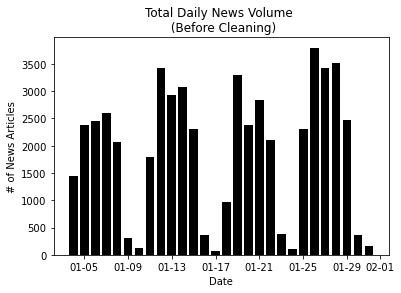

In [18]:
import matplotlib.dates as mdates
f,ax = plt.subplots(1,1)
ax.set_title("Total Daily News Volume \n (Before Cleaning)")
ax.bar(vol_df.date, vol_df.volume, color="black")
xfmt = mdates.DateFormatter('%m-%d')
ax.xaxis.set_major_formatter(xfmt)
ax.set_ylabel("# of News Articles")
ax.set_xlabel("Date")

In [19]:
cov_df = pd.DataFrame(df.groupby("date")["pos_mean"].count()).reset_index()
cov_df

,date,pos_mean
0,2021-01-04,245
1,2021-01-05,290
2,2021-01-06,259
3,2021-01-07,284
4,2021-01-08,259
5,2021-01-09,96
6,2021-01-10,52
7,2021-01-11,248
8,2021-01-12,298
9,2021-01-13,282


(0.0, 350.0)

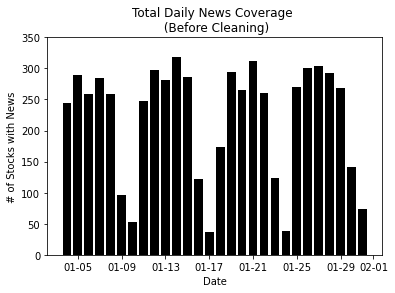

In [20]:
f,ax = plt.subplots(1,1)
ax.set_title("Total Daily News Coverage \n (Before Cleaning)")
ax.bar(cov_df.date, cov_df.pos_mean, color="black")
xfmt = mdates.DateFormatter('%m-%d')
ax.xaxis.set_major_formatter(xfmt)
ax.set_ylabel("# of Stocks with News")
ax.set_xlabel("Date")
ax.set_ylim(0,350)

Combine Saturdays and Holidays with previous day's score

In [21]:
date_cols = ["year", "month", "day"]
return_dates = return_df['date'].drop_duplicates().values.tolist()
return_dates

[1609718400000000000,
 1609804800000000000,
 1609891200000000000,
 1609977600000000000,
 1610064000000000000,
 1610323200000000000,
 1610409600000000000,
 1610496000000000000,
 1610582400000000000,
 1610668800000000000,
 1611014400000000000,
 1611100800000000000,
 1611187200000000000,
 1611273600000000000,
 1611532800000000000,
 1611619200000000000,
 1611705600000000000,
 1611792000000000000,
 1611878400000000000,
 1612137600000000000,
 1612224000000000000,
 1612310400000000000,
 1612396800000000000,
 1612483200000000000,
 1612742400000000000,
 1612828800000000000,
 1612915200000000000,
 1613001600000000000,
 1613088000000000000,
 1613433600000000000,
 1613520000000000000,
 1613606400000000000,
 1613692800000000000,
 1613952000000000000,
 1614038400000000000,
 1614124800000000000,
 1614211200000000000,
 1614297600000000000,
 1614556800000000000,
 1614643200000000000,
 1614729600000000000,
 1614816000000000000,
 1614902400000000000,
 1615161600000000000,
 1615248000000000000,
 161533440

In [22]:
return_cols = ['same_day_raw', 'next_day_raw',
       'sp_avg_return', 'next_day_sp', 'same_day_relative', 'next_day_relative']

In [23]:
def fix_wknds_holidays(df, return_dates):    
    ticker_nan = df[df['ticker'].isnull()]
    counter = 1
    while len(ticker_nan) != 0: # check if NaNs present
        ticker_nan.date = pd.DatetimeIndex(ticker_nan['date'])-dt.timedelta(counter) # move news back a day

        for i in range(len(ticker_nan)):
            if ticker_nan.date.iloc[i].value in return_dates: # if new dates are in return dates then add ticker
                ticker_nan.ticker.iloc[i] = ticker_nan.tags.iloc[i] # set ticker = tags
                date_returns = df[(df.date==ticker_nan.date.iloc[i]) & (df.ticker==ticker_nan.ticker.iloc[i])][return_cols]
                ticker_nan.iloc[i,-6:] = date_returns.iloc[0] # set returns equal to new date returns

        fixed_data = ticker_nan[ticker_nan.ticker.notnull()]
        df.loc[fixed_data.index, :] = fixed_data[:]
        ticker_nan = df[df['ticker'].isnull()]
        counter+=1 
    return(df)

In [24]:
fix_wknds_holidays_df = fix_wknds_holidays(df, return_dates)
fix_wknds_holidays_df

/Users/TyPainter1/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/TyPainter1/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/Users/TyPainter1/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1797: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

,ticker,year,date,month,day,tags,volume,pos_mean,pos_median,pos_min,...,net_median,net_min,net_max,read_score,same_day_raw,next_day_raw,sp_avg_return,next_day_sp,same_day_relative,next_day_relative
0,A,2021.0,2021-01-04,1.0,4.0,A,2.0,0.110000,0.000,0.0,...,0.000,-0.500000,1.000000,0.217502,0.252231,-0.953746,1.933110,-1.031859,-1.680879,0.135142
1,AAL,2021.0,2021-01-04,1.0,4.0,AAL,1.0,0.100000,0.000,0.0,...,0.000,-1.000000,1.000000,0.149566,4.542587,-3.418231,1.933110,-1.031859,2.609477,-2.073725
2,AAPL,2021.0,2021-01-04,1.0,4.0,AAPL,21.0,0.111429,0.000,0.0,...,0.000,-0.672857,0.851429,0.269487,3.078190,-1.644810,1.933110,-1.031859,1.145081,-0.064243
3,ABBV,2021.0,2021-01-04,1.0,4.0,ABBV,5.0,0.034000,0.000,0.0,...,0.000,-0.600000,0.600000,0.243894,1.651424,-1.034054,1.933110,-1.031859,-0.281686,1.948018
4,ABT,2021.0,2021-01-04,1.0,4.0,ABT,4.0,0.312500,0.115,0.0,...,0.115,-0.247500,1.000000,0.409763,0.383455,-1.479101,1.933110,-1.031859,-1.549655,0.236260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10532,BWA,NaN,2021-01-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.403221,0.307977,1.388965,-0.469278,-0.985744,2.781249
10533,LRCX,NaN,2021-01-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,4.170214,-2.117916,1.388965,-0.469278,2.781249,-0.033729
10534,NWL,NaN,2021-01-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.355236,-0.370370,1.388965,-0.469278,-0.033729,-0.482963
10535,UAA,NaN,2021-01-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.906002,-1.926346,1.388965,-0.469278,-0.482963,0.582067


In [25]:
# fix_wknds_holidays_df[fix_wknds_holidays_df[return_cols].isna().any(axis=1)]

### Recount Volume for Weekend and Holiday data

In [26]:
wh_count_df = pd.DataFrame(fix_wknds_holidays_df.groupby(["date", "tags", "ticker"], dropna=False)["volume"]
                        .sum()).reset_index()#.rename(columns={"volume":"volume2"})
wh_count_df

,date,tags,ticker,volume
0,2021-01-04,A,A,2.0
1,2021-01-04,AAL,AAL,1.0
2,2021-01-04,AAPL,AAPL,21.0
3,2021-01-04,ABBV,ABBV,5.0
4,2021-01-04,ABT,ABT,4.0
...,...,...,...,...
9821,2021-01-29,NaN,YUM,0.0
9822,2021-01-29,NaN,ZBH,0.0
9823,2021-01-29,NaN,ZBRA,0.0
9824,2021-01-29,NaN,ZION,0.0


### Resummarize Weekend and Holiday data

In [27]:
sum_cols = ['pos_mean', 'pos_median', 'pos_min',
       'pos_max', 'neg_mean', 'neg_median', 'neg_min', 'neg_max', 'neu_mean',
       'neu_median', 'neu_min', 'neu_max', 'net_mean', 'net_median', 'net_min',
       'net_max', 'read_score', 'same_day_raw', 'next_day_raw',
       'sp_avg_return', 'next_day_sp', 'same_day_relative', 'next_day_relative']

In [28]:
wh_summary_df = pd.DataFrame(fix_wknds_holidays_df.groupby(["date", "tags", "ticker"], dropna=False)[sum_cols]
                        .mean()).reset_index()
wh_summary_df

,date,tags,ticker,pos_mean,pos_median,pos_min,pos_max,neg_mean,neg_median,neg_min,...,net_median,net_min,net_max,read_score,same_day_raw,next_day_raw,sp_avg_return,next_day_sp,same_day_relative,next_day_relative
0,2021-01-04,A,A,0.110000,0.000,0.0,1.000000,0.015000,0.0,0.0,...,0.000,-0.500000,1.000000,0.217502,0.252231,-0.953746,1.933110,-1.031859,-1.680879,0.135142
1,2021-01-04,AAL,AAL,0.100000,0.000,0.0,1.000000,0.030000,0.0,0.0,...,0.000,-1.000000,1.000000,0.149566,4.542587,-3.418231,1.933110,-1.031859,2.609477,-2.073725
2,2021-01-04,AAPL,AAPL,0.111429,0.000,0.0,0.851429,0.122381,0.0,0.0,...,0.000,-0.672857,0.851429,0.269487,3.078190,-1.644810,1.933110,-1.031859,1.145081,-0.064243
3,2021-01-04,ABBV,ABBV,0.034000,0.000,0.0,0.600000,0.048000,0.0,0.0,...,0.000,-0.600000,0.600000,0.243894,1.651424,-1.034054,1.933110,-1.031859,-0.281686,1.948018
4,2021-01-04,ABT,ABT,0.312500,0.115,0.0,1.000000,0.015000,0.0,0.0,...,0.115,-0.247500,1.000000,0.409763,0.383455,-1.479101,1.933110,-1.031859,-1.549655,0.236260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9821,2021-01-29,NaN,YUM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.587715,-0.802034,1.388965,-0.469278,-0.801250,1.773387
9822,2021-01-29,NaN,ZBH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.493591,0.626332,1.388965,-0.469278,0.104626,0.192627
9823,2021-01-29,NaN,ZBRA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.635395,-1.445087,1.388965,-0.469278,-0.753570,-1.527676
9824,2021-01-29,NaN,ZION,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2.539196,-0.607700,1.388965,-0.469278,1.150231,-1.288998


In [29]:
wh_summary_df[wh_summary_df[return_cols].isna().any(axis=1)]

,date,tags,ticker,pos_mean,pos_median,pos_min,pos_max,neg_mean,neg_median,neg_min,...,net_median,net_min,net_max,read_score,same_day_raw,next_day_raw,sp_avg_return,next_day_sp,same_day_relative,next_day_relative


In [30]:
wh_final_df = wh_count_df.merge(wh_summary_df, 
              how="left", 
              on=["date", "tags", "ticker"])
wh_final_df

,date,tags,ticker,volume,pos_mean,pos_median,pos_min,pos_max,neg_mean,neg_median,...,net_median,net_min,net_max,read_score,same_day_raw,next_day_raw,sp_avg_return,next_day_sp,same_day_relative,next_day_relative
0,2021-01-04,A,A,2.0,0.110000,0.000,0.0,1.000000,0.015000,0.0,...,0.000,-0.500000,1.000000,0.217502,0.252231,-0.953746,1.933110,-1.031859,-1.680879,0.135142
1,2021-01-04,AAL,AAL,1.0,0.100000,0.000,0.0,1.000000,0.030000,0.0,...,0.000,-1.000000,1.000000,0.149566,4.542587,-3.418231,1.933110,-1.031859,2.609477,-2.073725
2,2021-01-04,AAPL,AAPL,21.0,0.111429,0.000,0.0,0.851429,0.122381,0.0,...,0.000,-0.672857,0.851429,0.269487,3.078190,-1.644810,1.933110,-1.031859,1.145081,-0.064243
3,2021-01-04,ABBV,ABBV,5.0,0.034000,0.000,0.0,0.600000,0.048000,0.0,...,0.000,-0.600000,0.600000,0.243894,1.651424,-1.034054,1.933110,-1.031859,-0.281686,1.948018
4,2021-01-04,ABT,ABT,4.0,0.312500,0.115,0.0,1.000000,0.015000,0.0,...,0.115,-0.247500,1.000000,0.409763,0.383455,-1.479101,1.933110,-1.031859,-1.549655,0.236260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9821,2021-01-29,NaN,YUM,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.587715,-0.802034,1.388965,-0.469278,-0.801250,1.773387
9822,2021-01-29,NaN,ZBH,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.493591,0.626332,1.388965,-0.469278,0.104626,0.192627
9823,2021-01-29,NaN,ZBRA,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.635395,-1.445087,1.388965,-0.469278,-0.753570,-1.527676
9824,2021-01-29,NaN,ZION,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2.539196,-0.607700,1.388965,-0.469278,1.150231,-1.288998


Text(0.5, 0, 'Date')

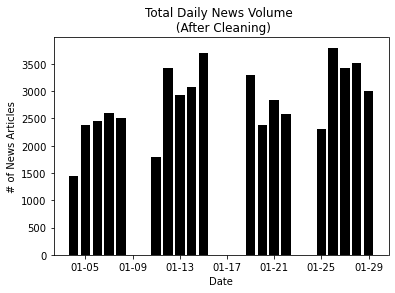

In [31]:
vol_df2 = pd.DataFrame(wh_final_df.groupby("date")["volume"].sum()).reset_index()
f,ax = plt.subplots(1,1)
ax.set_title("Total Daily News Volume \n (After Cleaning)")
ax.bar(vol_df2.date, vol_df2.volume, color="black")
xfmt = mdates.DateFormatter('%m-%d')
ax.xaxis.set_major_formatter(xfmt)
ax.set_ylabel("# of News Articles")
ax.set_xlabel("Date")

(0.0, 350.0)

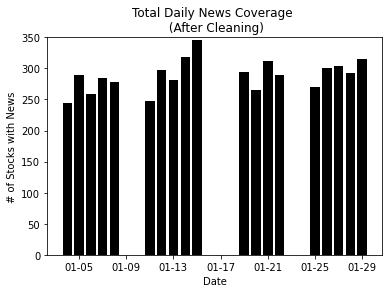

In [32]:
cov_df2 = pd.DataFrame(wh_final_df.groupby("date")["pos_mean"].count()).reset_index()
f,ax = plt.subplots(1,1)
ax.set_title("Total Daily News Coverage \n (After Cleaning)")
ax.bar(cov_df2.date, cov_df2.pos_mean, color="black")
xfmt = mdates.DateFormatter('%m-%d')
ax.xaxis.set_major_formatter(xfmt)
ax.set_ylabel("# of Stocks with News")
ax.set_xlabel("Date")
ax.set_ylim(0,350)

## Fix Missing News Sentiment (missing Tags)

In [121]:
sent_nan = wh_final_df[wh_final_df.tags.isnull()]
sent_nan

,date,tags,ticker,volume,pos_mean,pos_median,pos_min,pos_max,neg_mean,neg_median,...,net_median,net_min,net_max,read_score,same_day_raw,next_day_raw,sp_avg_return,next_day_sp,same_day_relative,next_day_relative
245,2021-01-04,NaN,AAP,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.354654,-0.601678,1.933110,-1.031859,-1.578456,1.087381
246,2021-01-04,NaN,ABC,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.379661,-1.064819,1.933110,-1.031859,-0.553449,-0.654681
247,2021-01-04,NaN,ABMD,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2.415502,-1.834022,1.933110,-1.031859,0.482392,-0.184021
248,2021-01-04,NaN,AEE,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.944876,0.824711,1.933110,-1.031859,0.011766,1.229909
249,2021-01-04,NaN,AIZ,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,3.010062,0.158663,1.933110,-1.031859,1.076952,-1.091268
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9821,2021-01-29,NaN,YUM,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.587715,-0.802034,1.388965,-0.469278,-0.801250,1.773387
9822,2021-01-29,NaN,ZBH,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.493591,0.626332,1.388965,-0.469278,0.104626,0.192627
9823,2021-01-29,NaN,ZBRA,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.635395,-1.445087,1.388965,-0.469278,-0.753570,-1.527676
9824,2021-01-29,NaN,ZION,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2.539196,-0.607700,1.388965,-0.469278,1.150231,-1.288998


In [122]:
sent_cols = ['volume', 'pos_mean', 'pos_median', 'pos_min',
       'pos_max', 'neg_mean', 'neg_median', 'neg_min', 'neg_max', 'neu_mean',
       'neu_median', 'neu_min', 'neu_max', 'net_mean', 'net_median', 'net_min',
       'net_max', 'read_score']

In [123]:
def fix_sent(na_df, df):
    for i in range(len(na_df)):
        date0 = na_df.date.iloc[i]
        ticker = na_df.ticker.iloc[i]

        lag1 = df[(df.date==date0-dt.timedelta(1)) & (df.ticker==ticker)][sent_cols]
        if len(lag1) == 0:
            lag1 = pd.DataFrame(np.zeros((1, lag1.shape[1])), columns=lag1.columns)
        else: lag1=lag1.fillna(0)

        lag2 = df[(df.date==date0-dt.timedelta(2)) & (df.ticker==ticker)][sent_cols]
        if len(lag2) == 0:
            lag2 = pd.DataFrame(np.zeros((1, lag2.shape[1])), columns=lag2.columns)
        else: lag2=lag2.fillna(0)

        lag3 = df[(df.date==date0-dt.timedelta(3)) & (df.ticker==ticker)][sent_cols]
        if len(lag3) == 0:
            lag3 = pd.DataFrame(np.zeros((1, lag3.shape[1])), columns=lag3.columns)
        else: lag3=lag3.fillna(0)

        l1 = lag1*.7
        l2 = lag2*.2
        l3 = lag3*.1
        na_df.iloc[i,3:21]=np.array(pd.concat([l1,l2,l3]).sum())
        na_df.iloc[i,1] = na_df.iloc[i,2]
    return(na_df)

In [99]:
# na_df = sent_nan
# i=110
# date0 = na_df.date.iloc[i]
# ticker = na_df.ticker.iloc[i]

# lag1 = df[(df.date==date0-dt.timedelta(1)) & (df.ticker==ticker)][sent_cols]
# if len(lag1) == 0:
#     lag1 = pd.DataFrame(np.zeros((1, lag1.shape[1])), columns=lag1.columns)
# else: lag1=lag1.fillna(0)

# lag2 = df[(df.date==date0-dt.timedelta(2)) & (df.ticker==ticker)][sent_cols]
# if len(lag2) == 0:
#     lag2 = pd.DataFrame(np.zeros((1, lag2.shape[1])), columns=lag2.columns)
# else: lag2=lag2.fillna(0)

# lag3 = df[(df.date==date0-dt.timedelta(3)) & (df.ticker==ticker)][sent_cols]
# if len(lag3) == 0:
#     lag3 = pd.DataFrame(np.zeros((1, lag3.shape[1])), columns=lag3.columns)
# else: lag3=lag3.fillna(0)

# l1 = lag1*.7
# l2 = lag2*.2
# l3 = lag3*.1
# print(l1)
# print(l2)
# print(l3)

   volume  pos_mean  pos_median  pos_min  pos_max  neg_mean  neg_median  \
0     0.0       0.0         0.0      0.0      0.0       0.0         0.0   

   neg_min  neg_max  neu_mean  neu_median  neu_min  neu_max  net_mean  \
0      0.0      0.0       0.0         0.0      0.0      0.0       0.0   

   net_median  net_min  net_max  read_score  
0         0.0      0.0      0.0         0.0  
   volume  pos_mean  pos_median  pos_min  pos_max  neg_mean  neg_median  \
0     0.0       0.0         0.0      0.0      0.0       0.0         0.0   

   neg_min  neg_max  neu_mean  neu_median  neu_min  neu_max  net_mean  \
0      0.0      0.0       0.0         0.0      0.0      0.0       0.0   

   net_median  net_min  net_max  read_score  
0         0.0      0.0      0.0         0.0  
   volume  pos_mean  pos_median  pos_min  pos_max  neg_mean  neg_median  \
0     0.0       0.0         0.0      0.0      0.0       0.0         0.0   

   neg_min  neg_max  neu_mean  neu_median  neu_min  neu_max  net_mean

In [107]:
len(na_df)

4334

In [124]:
na_df.iloc[-5]

date                 2021-01-29 00:00:00
tags                                 YUM
ticker                               YUM
volume                               2.2
pos_mean                          0.2955
pos_median                      0.199333
pos_min                              0.0
pos_max                            0.985
neg_mean                        0.028667
neg_median                           0.0
neg_min                              0.0
neg_max                         0.462667
neu_mean                        0.677833
neu_median                        0.7665
neu_min                            0.015
neu_max                              1.0
net_mean                        0.266833
net_median                      0.197333
net_min                        -0.462667
net_max                            0.985
read_score                      0.362005
same_day_raw                    0.587715
next_day_raw                   -0.802034
sp_avg_return                   1.388965
next_day_sp     

In [125]:
sent_final_df = fix_sent(sent_nan, wh_final_df)
sent_final_df

/Users/TyPainter1/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1797: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, v, pi)
/Users/TyPainter1/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,date,tags,ticker,volume,pos_mean,pos_median,pos_min,pos_max,neg_mean,neg_median,...,net_median,net_min,net_max,read_score,same_day_raw,next_day_raw,sp_avg_return,next_day_sp,same_day_relative,next_day_relative
245,2021-01-04,AAP,AAP,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.354654,-0.601678,1.933110,-1.031859,-1.578456,1.087381
246,2021-01-04,ABC,ABC,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,1.379661,-1.064819,1.933110,-1.031859,-0.553449,-0.654681
247,2021-01-04,ABMD,ABMD,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,2.415502,-1.834022,1.933110,-1.031859,0.482392,-0.184021
248,2021-01-04,AEE,AEE,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,1.944876,0.824711,1.933110,-1.031859,0.011766,1.229909
249,2021-01-04,AIZ,AIZ,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,3.010062,0.158663,1.933110,-1.031859,1.076952,-1.091268
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9821,2021-01-29,YUM,YUM,2.2,0.295500,0.199333,0.0,0.985000,0.028667,0.0,...,0.197333,-0.462667,0.985000,0.362005,0.587715,-0.802034,1.388965,-0.469278,-0.801250,1.773387
9822,2021-01-29,ZBH,ZBH,2.0,0.263333,0.000000,0.0,0.766667,0.079000,0.0,...,0.000000,-0.766667,0.766667,0.345520,1.493591,0.626332,1.388965,-0.469278,0.104626,0.192627
9823,2021-01-29,ZBRA,ZBRA,0.8,0.017500,0.000000,0.0,0.100000,0.023000,0.0,...,0.000000,-0.222000,0.100000,0.112321,0.635395,-1.445087,1.388965,-0.469278,-0.753570,-1.527676
9824,2021-01-29,ZION,ZION,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,2.539196,-0.607700,1.388965,-0.469278,1.150231,-1.288998


### Merge Lag Sentiments 

In [114]:
# # df_new = wh_final_df.merge(sent_final_df, 
# #                            how='left',  # ??????
# #                            indicator=True)
# # df_new
# final_fixed_df = wh_final_df
# final_fixed_df.update(sent_final_df)
# final_fixed_df

,date,tags,ticker,volume,pos_mean,pos_median,pos_min,pos_max,neg_mean,neg_median,...,net_median,net_min,net_max,read_score,same_day_raw,next_day_raw,sp_avg_return,next_day_sp,same_day_relative,next_day_relative
0,2021-01-04,A,A,2.0,0.110000,0.000000,0.0,1.000000,0.015000,0.0,...,0.000000,-0.500000,1.000000,0.217502,0.252231,-0.953746,1.933110,-1.031859,-1.680879,0.135142
1,2021-01-04,AAL,AAL,1.0,0.100000,0.000000,0.0,1.000000,0.030000,0.0,...,0.000000,-1.000000,1.000000,0.149566,4.542587,-3.418231,1.933110,-1.031859,2.609477,-2.073725
2,2021-01-04,AAPL,AAPL,21.0,0.111429,0.000000,0.0,0.851429,0.122381,0.0,...,0.000000,-0.672857,0.851429,0.269487,3.078190,-1.644810,1.933110,-1.031859,1.145081,-0.064243
3,2021-01-04,ABBV,ABBV,5.0,0.034000,0.000000,0.0,0.600000,0.048000,0.0,...,0.000000,-0.600000,0.600000,0.243894,1.651424,-1.034054,1.933110,-1.031859,-0.281686,1.948018
4,2021-01-04,ABT,ABT,4.0,0.312500,0.115000,0.0,1.000000,0.015000,0.0,...,0.115000,-0.247500,1.000000,0.409763,0.383455,-1.479101,1.933110,-1.031859,-1.549655,0.236260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9821,2021-01-29,YUM,YUM,2.2,0.295500,0.199333,0.0,0.985000,0.028667,0.0,...,0.197333,-0.462667,0.985000,0.362005,0.587715,-0.802034,1.388965,-0.469278,-0.801250,1.773387
9822,2021-01-29,ZBH,ZBH,2.0,0.263333,0.000000,0.0,0.766667,0.079000,0.0,...,0.000000,-0.766667,0.766667,0.345520,1.493591,0.626332,1.388965,-0.469278,0.104626,0.192627
9823,2021-01-29,ZBRA,ZBRA,0.8,0.017500,0.000000,0.0,0.100000,0.023000,0.0,...,0.000000,-0.222000,0.100000,0.112321,0.635395,-1.445087,1.388965,-0.469278,-0.753570,-1.527676
9824,2021-01-29,ZION,ZION,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,2.539196,-0.607700,1.388965,-0.469278,1.150231,-1.288998


In [126]:
final_fixed_df[final_fixed_df.isna().any(axis=1)]

,date,tags,ticker,volume,pos_mean,pos_median,pos_min,pos_max,neg_mean,neg_median,...,net_median,net_min,net_max,read_score,same_day_raw,next_day_raw,sp_avg_return,next_day_sp,same_day_relative,next_day_relative


In [131]:
wh_final_df[(wh_final_df.ticker=='YUM') & (wh_final_df.date>=datetime(year=2021, month=1, day=26))].to_excel("scores_before.xlsx")

In [132]:
final_fixed_df[(final_fixed_df.ticker=='YUM') & (final_fixed_df.date>=datetime(year=2021, month=1, day=26))].to_excel("scores_after.xlsx")

In [ ]:
final_fixed_df.to_csv("../00-data/portfolio_data/2021/portfolio_jan2021.csv",index=False)